In [1]:
# import standard libraries
import numpy as np
from scipy.io import mmread, mmwrite
from scipy import linalg
from scipy import sparse
from numba import njit
import matplotlib.pyplot as plt
from pyscf import gto, dft
import numpy.ma as ma

# import methods for solving from other files
import dmm_gcp as gcp
import dmm_cp as cp
import palser as pals
import ntpoly as nt

# Note: using np.sum(A * B.T) for matrices A, B is equivalent to Trace(A^dag B)

In [2]:
# First generate a random hamiltonian of the Huckel model
# i.e. alpha on the diagonal, and beta on the off-diagonals to represent nearest neighbors
#    for now use random alpha and beta
np.random.seed(2)
alpha = np.random.random()
beta = np.random.random()

# define the dimensions of the Hamiltonian and how many elements to consider before cutoff
size = 50
n_cutoff = 9
H = pals.generate_H(n_cutoff, size, beta, alpha)
H_spect = linalg.eigvalsh(H)

# define a chemical potential mu (for now use random)
num_electrons = int(0.5*H.shape[0])
mu = (H_spect[num_electrons] + H_spect[num_electrons-1])/2
#mu = 1

In [3]:
# Perform Palser GCP method
palser_gcp_rho = pals.gcp(mu, H, 1000)
palser_gcp_energy = np.sum(palser_gcp_rho * H.T)

palser_cp_rho = pals.cp(num_electrons, H, 1000)
palser_cp_energy = np.sum(palser_cp_rho * H.T)

GCP steps:  19
CP steps:  0


In [4]:
# perform our GCP and CP methods
dbeta = 0.003
ovlp = np.identity(H.shape[0], dtype=complex)
#inv_ovlp = linalg.inv(ovlp)
init_rho = ovlp/2

dmm_gcp_rho = gcp.rk4(gcp.rhs, init_rho, 0.003, H, ovlp, ovlp, mu, 1000)
dmm_cp_rho = cp.rk4(cp.rhs, init_rho, 0.003, H, ovlp, ovlp, 1000)

Text(0.5, 0, 'Iteration #')

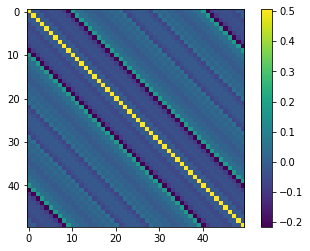

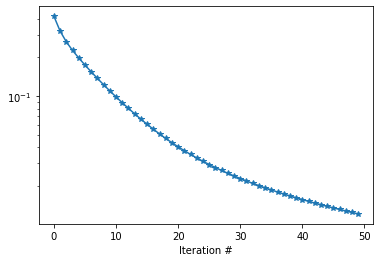

In [5]:
# Apply Aitkens convergence to our methods
func_args = {'h': H, 'mu': mu, 'inv_ovlp': ovlp, 'dbeta': dbeta, 'rk4steps': 1000}
gcp_aitkens, norm_diff = gcp.aitkens(dmm_gcp_rho.copy(), 50, gcp.linear_single_step, func_args)

plt.figure(1)
plt.imshow(gcp_aitkens.real)
plt.colorbar()

plt.figure(2)
plt.semilogy(norm_diff, '*-')
plt.xlabel("Iteration #")

In [6]:
# perform method using NTPoly (Only CP for now)
ntpoly_cp_rho = nt.NTPoly_cp(H, ovlp, num_electrons)

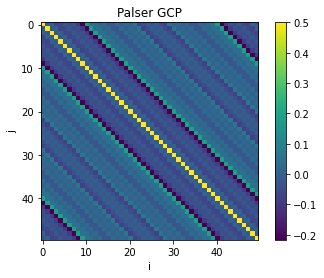

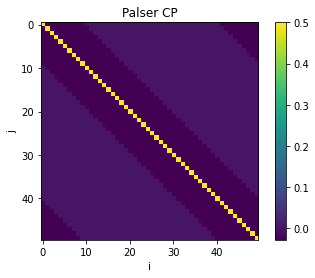

In [7]:
plt.figure(1)
plt.imshow(palser_gcp_rho.real)
plt.title("Palser GCP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

plt.figure(2)
plt.imshow(palser_cp_rho.real)
plt.title("Palser CP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

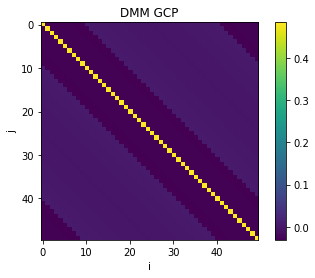

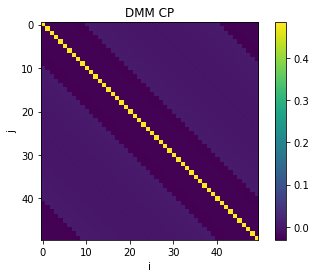

In [8]:
plt.figure(1)
plt.imshow(dmm_gcp_rho.real)
plt.title("DMM GCP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

plt.figure(2)
plt.imshow(dmm_cp_rho.real)
plt.title("DMM CP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

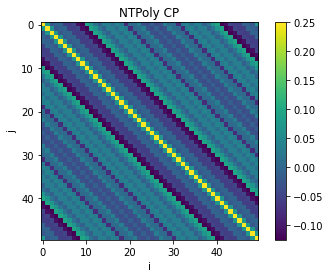

In [9]:
plt.imshow(ntpoly_cp_rho.real)
plt.title("NTPoly CP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

In [10]:
exact_2 = linalg.funm(H, lambda _: _ <= mu)

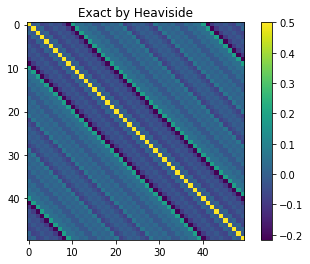

In [11]:
plt.imshow(exact_2.real)
plt.title("Exact by Heaviside")
plt.colorbar()

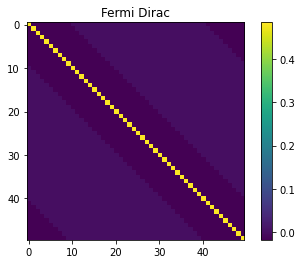

In [12]:
exact3 = linalg.funm(H, lambda _: 1/(1+np.exp(1000*dbeta*(_ - mu))))
plt.imshow(exact3.real)
plt.title("Fermi Dirac")
plt.colorbar()

In [13]:
eig_spect = linalg.eigvalsh(H)
print(eig_spect)

[0.30602314 0.30602314 0.3511575  0.3511575  0.36320332 0.36320332
 0.38165872 0.38165872 0.38414244 0.38414244 0.38414244 0.38414244
 0.38414244 0.38414244 0.38414244 0.38414244 0.38414244 0.3922945
 0.3922945  0.40050572 0.40050572 0.40332369 0.40332369 0.40838795
 0.40838795 0.41673301 0.41673301 0.41770503 0.41770503 0.42387248
 0.42387248 0.42911829 0.42911829 0.43186259 0.43186259 0.43395044
 0.43395044 0.43942117 0.43942117 0.44727138 0.44727138 0.46342808
 0.46342808 0.46433428 0.46433428 0.55167299 0.55167299 0.79397377
 0.79397377 0.90266708]


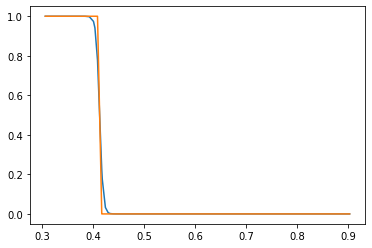

In [14]:
plt.plot(eig_spect, 1/(1+np.exp(100000*dbeta*(eig_spect - mu))))
plt.plot(eig_spect, eig_spect <= mu)

In [15]:
palser_cp_energy

(10.25171675785281+0j)

In [16]:
palser_gcp_energy

(9.470391012106386+0j)

Iterations converged!


Text(0.5, 0, 'Iteration #')

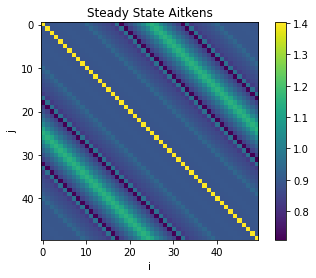

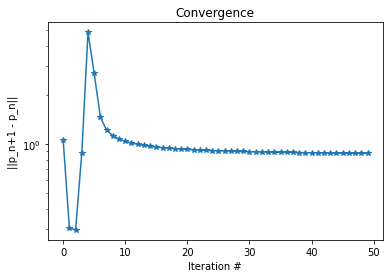

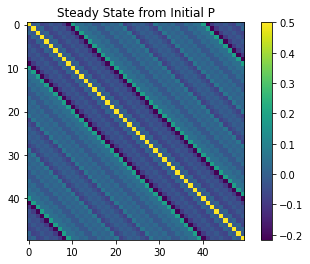

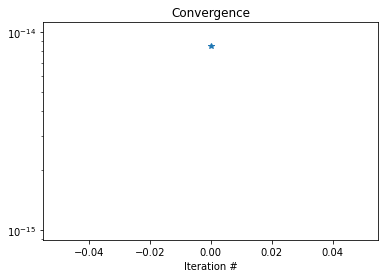

In [20]:
func_args = {'h':H, 'mu': mu}
steady_state_aitkens, norm_diff = gcp.aitkens(init_rho.copy(), 50, gcp.steady_linear_single_step, func_args)

plt.figure(1)
plt.imshow(steady_state_aitkens.real)
plt.title("Steady State Aitkens")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

plt.figure(2)
plt.semilogy(norm_diff, '*-')
plt.xlabel("Iteration #")
plt.ylabel("||p_n+1 - p_n||")
plt.title("Convergence")

steady_state_aitkens2, norm_diff = gcp.aitkens(exact_2.copy(), 50, gcp.steady_linear_single_step, func_args)
plt.figure(3)
plt.imshow(steady_state_aitkens2.real)
plt.title("Steady State from Initial P")
plt.colorbar()

plt.figure(4)
plt.semilogy(norm_diff, "*-")
plt.title("Convergence")
plt.xlabel("Iteration #")

In [28]:
rho = init_rho.copy()
norm_diff = []
for i in range(300):
    rho_next = gcp.steady_linear_single_step(rho, **func_args)
    norm_diff.append(linalg.norm(rho_next - rho))
    rho = rho_next
    if norm_diff[-1] < 1e-10:
        break


7.038366826131214


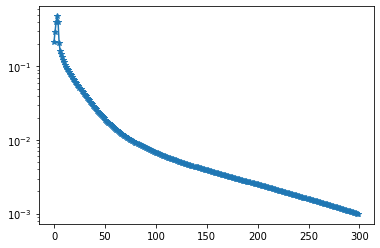

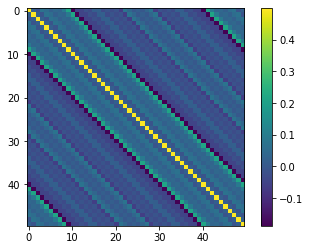

In [31]:
plt.semilogy(norm_diff, '*-')

plt.figure(2)
plt.imshow(rho.real)
plt.colorbar()

print(linalg.norm(exact_2 - rho))

In [19]:
# Norm differences for GCP
print("DMM vs Exact: ", linalg.norm(dmm_gcp_rho - exact_rho))
print("Palser vs Exact: ", linalg.norm(palser_gcp_rho - exact_rho))
print("DMM vs Palser: ", linalg.norm(dmm_gcp_rho - palser_gcp_rho))

# Norm differences for CP
print("DMM vs Exact: ", linalg.norm(dmm_cp_rho - exact_rho))
print("Palser vs Exact: ", linalg.norm(palser_cp_rho - exact_rho))
print("NTPoly vs Exact: ", linalg.norm(ntpoly_cp_rho - exact_rho))
print("DMM vs Palser: ", linalg.norm(dmm_cp_rho - palser_cp_rho))
print("DMM vs NTPoly: ", linalg.norm(dmm_cp_rho - ntpoly_cp_rho))

NameError: name 'exact_rho' is not defined